In [7]:
import numpy
import matplotlib.pyplot as plt
from numpy import vstack, array
import math


In [12]:
def odeint(function, initial, time):
    
    length = time[1] - time[0]
    intvals = array(initial)
    matrix = intvals
    
    for n in range(len(time)-1):
        
        DE1 = function(intvals, 0)
        DE = array(DE1)
        initial_new = intvals + DE*length
        matrix = vstack([matrix, initial_new])
        intvals = initial_new

        
    return matrix

### Tutorial 8


We will continue with the _A.succinogenes_ example of [tut 4](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/Tut%204.ipynb). 

<img src="succmap_num.png" width="550" />

The fluxes are numbered in the figure above and the first seven equations of the model is supplied in hidden format in [Tut8eq.xlsx](https://github.com/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/Tut8eq.xlsx). Equation 7 represents the energy balance. All equations are equal to zero except the energy balance that is equal to $\theta$. All rates correspond to the flux numbers on the map.

You can use your own model or the supplied model. Assume the absence of pyruvate formate lyase (PFL). 

The physiological parameters can be taken as:

|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu \qquad$|$\theta\qquad$
|----|-|-|-|-
|$\frac{\text{cmol $CO_2$}}{\text{cmol X}}$|$\frac{\text{mol ATP}}{\text{cmol X}}$|$\frac{1}{\text{h}}$|$\frac{\text{mol ATP}}{\text{cmol X}\cdot \text{h}}$
|0.12|1.8|0.15|0.1

The biomass formula is given by $CH_{1.9}O_{0.45}N_{0.23}$

It is easy to transfer the $7 \times 9$ matrix into Python and add specification equations. You can use the code below. Ensure that the Excel file is in the same directory as the Jupyter notebook file.


In [13]:
import pandas, numpy
S1 = numpy.matrix(pandas.read_excel('Tut8eq.xlsx'))
S = numpy.vstack([S1,[0,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0]]) # Adding mu and zero PFL spec.

print(numpy.round(S, 2))

[[-0.1   0.11  0.4  -0.7  -0.3   0.    0.4   0.4   0.4 ]
 [ 0.    0.   -0.1   0.4   0.63 -0.4  -0.3  -0.3  -0.3 ]
 [ 0.    0.    0.    0.17 -0.4   0.3   0.1   0.1  -0.3 ]
 [ 0.    0.03  0.13 -0.2   0.13 -0.3   0.    0.4   0.3 ]
 [ 0.   -0.03 -0.1   0.13  0.    0.15  0.   -0.3  -0.2 ]
 [ 0.    0.02  0.07 -0.1  -0.4   0.2   0.1   0.3   0.1 ]
 [ 0.   -1.82 -0.07  0.53  0.33  0.27  0.   -0.2   0.2 ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.  ]]


a) Given an initial glucose concentration of 100 $\frac{\text{g}}{\text{L}}$ and biomass concentration of 0.001 $\frac{\text{cmol X}}{\text{L}}$, determine the time required to convert all the glucose. [43.9h] 

In [14]:
def response_fun(C):
    
    if C[0]<=0:               # glucose concentration
        return [0,0,0,0,0,0,0,0,0] 
    
    else:
        mu, theta= 0.15,0.1

        K = numpy.matrix([0, 0, 0, 0, 0, 0, theta, mu, 0]).T
        r = numpy.linalg.solve(S, K) 

        return ([-r[0,0],   # important to see the order of the rates (X,S,G,E)
                r[1,0],
                r[2,0],    # glucose, note the negative since the flux model calculated (-rs)
                r[3,0],   # glycerol
                r[4,0],
                r[5,0],    # glucose, note the negative since the flux model calculated (-rs)
                r[6,0],   # glycerol
                r[7,0],
                r[8,0]])   # ethanol   

In [15]:
def ferm_eq(C,t):
      # order of components very important 
    r=response_fun(C)      # this is the 'fetching' from the response function
    
    return [r[0]*C[1],
            r[1]*C[1],    
            r[2]*C[1],
            r[3]*C[1],
            r[4]*C[1],
            r[5]*C[1],    
            r[6]*C[1],
            r[7]*C[1],
            r[8]*C[1]]   

2000
[[  4.11184211e+00   1.00000000e-03   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.11182421e+00   1.00337669e-03   1.41092812e-05 ...,   0.00000000e+00
    1.47202508e-06   2.94405015e-06]
 [  4.11180626e+00   1.00676478e-03   2.82662051e-05 ...,   0.00000000e+00
    2.94902072e-06   5.89804144e-06]
 ..., 
 [ -9.16287602e-03   7.78777407e-01   3.24989429e+00 ...,   0.00000000e+00
    3.39062338e-01   6.78124677e-01]
 [ -9.16287602e-03   7.78777407e-01   3.24989429e+00 ...,   0.00000000e+00
    3.39062338e-01   6.78124677e-01]
 [ -9.16287602e-03   7.78777407e-01   3.24989429e+00 ...,   0.00000000e+00
    3.39062338e-01   6.78124677e-01]]


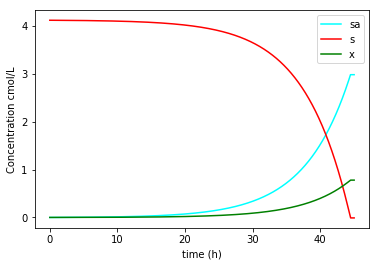

In [17]:
Co=[100/24.32, 0.001, 0, 0, 0, 0, 0, 0, 0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=45                                    # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,2000)           # define the timespan of the integration
C = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

print(len(C))

print (C)

Cs=C[:,0]
Cx=C[:,1]                                  

Csa=C[:,5]
Ce=C[:,3]

#plt.plot(tspan, Ce, color='blue', label='e')
plt.plot(tspan, Csa, color='cyan', label='sa')
plt.plot(tspan, Cs, color='red',label='s')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

In [18]:
tfin=numpy.interp(0,Cs[::-1],tspan[::-1])
print(tfin)

44.44487586566198


b) Determine the yield of succinic acid on glucose in $\frac{cmol}{cmol}$ by taking the amount of glucose converted and succininc acid formed throughout the whole run. How does this compare to the yields that the stoichiometric matrix predict and why? [0.722]

In [19]:
Ys_sa = Csa[1999]/Cs[0]
print(Ys_sa)

0.723992543994


c) Solve analytically for the biomass equation in the fermenter equation and plot against the answer obtained in (a). Integrate upto 45 hours. Why is it possible to solve for the biomass profile separately? At what point in time do the two profiles vary and why? 

It is because mu is consant (until there is no more biomass then it becomes zero)

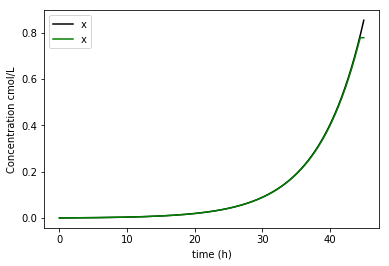

In [20]:
mu = 0.15

time = numpy.linspace(0, 45, 200)
list1 = []

for i in range(2000):
    
    X = 0.001*math.exp(mu*tspan[i]) 
    
    list1.append(X)

    
plt.plot(tspan, list1, color='k',label='x')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

d) Plot the rate of succinic acid production ($r_{SA}$) against time and comment.

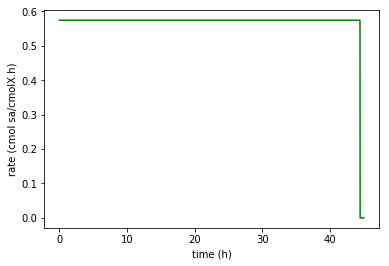

In [21]:
rSA = []

for n in range(2000):
    
    r = response_fun(C[n])
    rSA.append(r[5])

plt.plot(tspan, rSA, color='green',label='x')
#plt.legend(loc='best')
plt.ylabel('rate (cmol sa/cmolX.h)') 
plt.xlabel('time (h)') 
plt.show()

e) Plot the volumetric rate of succininc acid production ($r^V_{SA}$) against time and comment.

<img src="tut8e.png" width="500" />

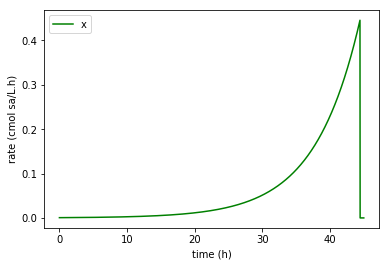

In [22]:
rSA_v = []

for n in range(2000):
    
    r = ferm_eq(C[n], 0)

    rx_v=r[1] 
    rsa_v=r[5]
    
    rSA_v.append(rsa_v)

plt.plot(tspan, rSA_v, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('rate (cmol sa/L.h)') 
plt.xlabel('time (h)') 
plt.show()

f) If the initial biomass concentration is changed to 0.0001 $\frac{\text{cmol X}}{\text{L}}$, how long will it take to convert all the glucose? [58.4h] 

g) Change the glucose initial concentration to 60 $\frac{\text{g}}{\text{L}}$ and determine how long it will take to convert all the glucose by using $C^O_X$ of (f)? [55.2h]  

h) For the conditions in (g), what is the succininc acid concentration in $\frac{cmol}{L}$ after 20 hours? [0.692]

i) Assume that $\theta=0$ and determine how long will it take to convert all the glucose by using the conditions of (g). Comment on your answer.[56.6h] 

j) Plot the succininc acid profiles of (g) and (i) on the same graph and comment.

<img src="tut8j.png" width="500" />

[Back to all tutorials](http://localhost:8888/notebooks/Dropbox/1_CBI%20310/2017/Tutorials/All%20tutorials.ipynb)